<a href="https://colab.research.google.com/github/Nabila310/2025_Visi-Komputer_TI2A/blob/main/Jobsheet_03_Teknik_Regresi_Gambar_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
Praktikum D2-Menebak Umur Manusia dari Foto Wajah(UTKFace)

SyntaxError: invalid syntax (ipython-input-997207589.py, line 1)

In [2]:
# Jalankan ini di awal notebook
from google.colab import files
files.upload()  # pilih file kaggle.json dari komputer Anda


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nabilaramadani","key":"9783115b33e8e7597deb58fbc73c83d9"}'}

In [3]:
import os, shutil

if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print("kaggle.json belum ditemukan. Upload terlebih dahulu.")


✅ Kaggle API siap digunakan.


In [4]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")


Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
✅ Dataset UTKFace berhasil diekstrak.


Total gambar ditemukan: 23708


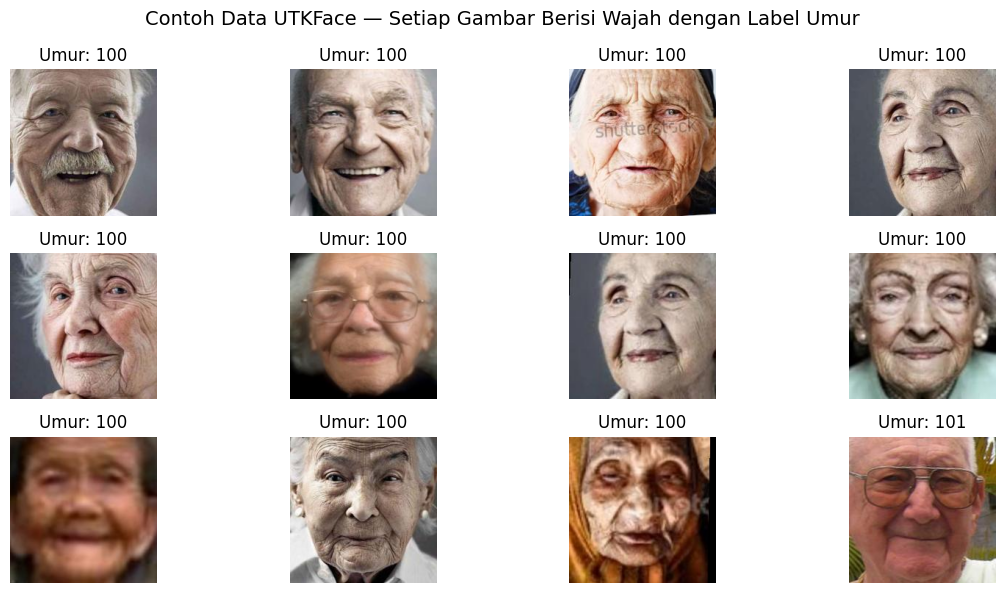

In [5]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
    # Ambil umur dari nama file
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")

plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()


In [6]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
    return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)

train_files, test_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42
)

IMG_SIZE = 160

def load_img(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)

print("✅ Dataset siap dilatih.")


✅ Dataset siap dilatih.


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False  # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)  # output tunggal: umur
model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])

model.summary()


Hardware: GPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 58s 135ms/step - loss: 339.6339 - mae: 13.5488 - val_loss: 158.2664 - val_mae: 9.5797 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 154.9890 - mae: 9.2249 - val_loss: 147.5170 - val_mae: 9.1578 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - loss: 145.7470 - mae: 8.8684 - val_loss: 141.0611 - val_mae: 8.8514 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 141.3744 - mae: 8.7232 - val_loss: 138.4289 - val_mae: 8.7133 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 136.6591 - mae: 8.5520 - val_loss: 137.3924 - val_mae: 8.6447 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 137.2060 - mae: 8.5559 - val_loss: 136.1989 - val_mae: 8.6207 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 136.7012 - mae: 8.5245 - val_loss: 135.7788 - va

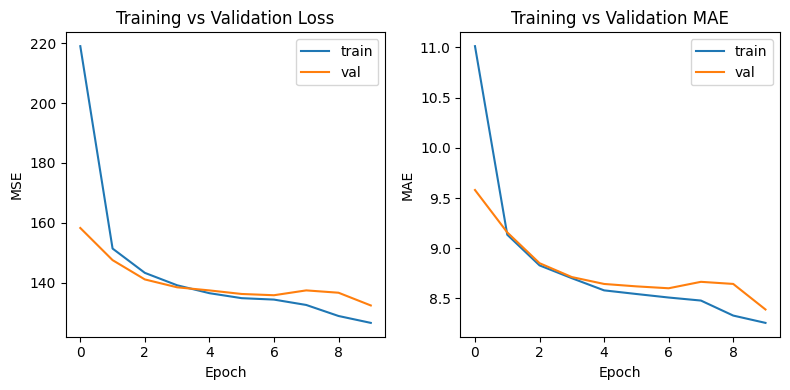

In [8]:
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 191.3328 - mae: 10.1462 - val_loss: 144.1706 - val_mae: 8.7919 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 77.5640 - mae: 6.5105 - val_loss: 125.1269 - val_mae: 8.4405 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - loss: 51.5256 - mae: 5.3287 - val_loss: 121.0213 - val_mae: 8.2949 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - loss: 38.7685 - mae: 4.6662 - val_loss: 108.0708 - val_mae: 7.6065 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - loss: 30.7410 - mae: 4.1670 - val_loss: 109.2982 - val_mae: 7.4315 - learning_rate: 1.0000e-04


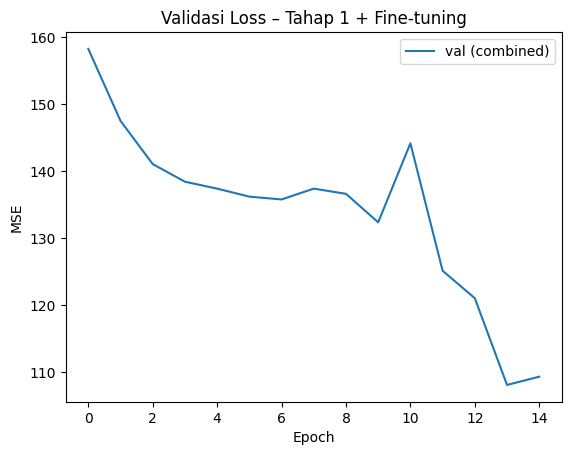

In [9]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False  # beku sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Visualisasi gabungan training dan fine-tuning
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()


MAE  = 7.61 tahun
RMSE = 10.40 tahun
R²   = 0.728


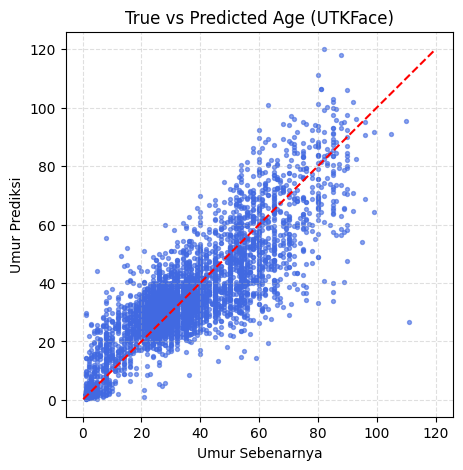

In [10]:
from math import sqrt

y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])

mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

print(f"MAE  = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R²   = {r2:.3f}")

# Plot “umur sebenarnya vs umur prediksi”
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


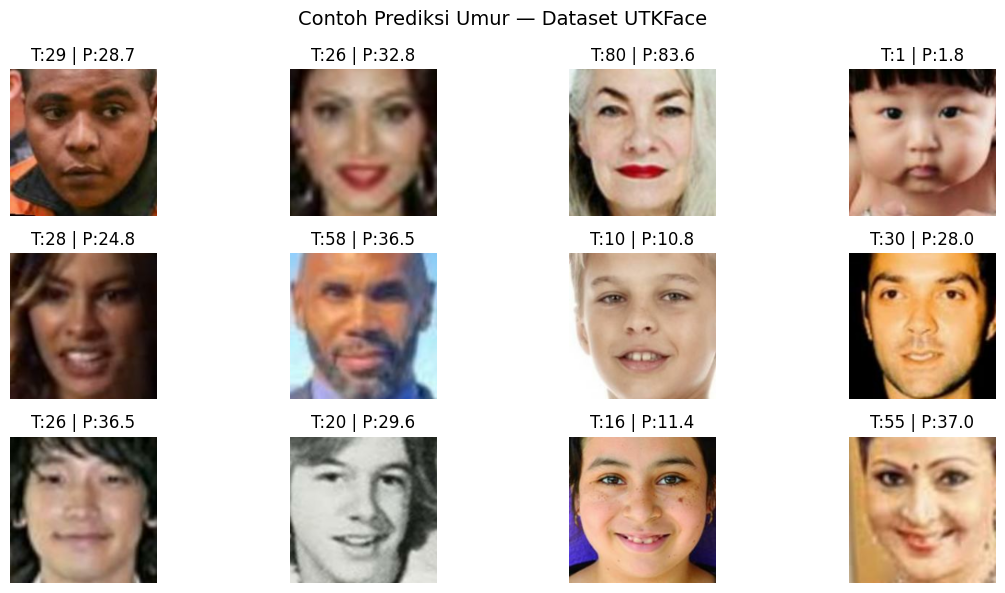

In [11]:
import random

sample_paths = random.sample(test_files, 12)

plt.figure(figsize=(12, 6))
for i, path in enumerate(sample_paths):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    true_age = int(os.path.basename(path).split('_')[0])
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
    plt.subplot(3, 4, i + 1)
    plt.imshow(img.numpy())
    plt.title(f"T:{true_age} | P:{pred_age:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()


Praktikum D1-Regresi dan Citra Sintesis(Prediksi Radius lingkaran)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
    r = np.random.randint(min_r, max_r + 1)  # radius acak
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    cx = np.random.randint(r, img_size - r)  # center-x
    cy = np.random.randint(r, img_size - r)  # center-y
    cv2.circle(img, (cx, cy), r, (255,), -1)  # lingkaran putih terisi
    img = (img / 255.0).astype(np.float32)
    # 3-channel biar kompatibel CNN
    img3 = np.stack([img, img, img], axis=-1)
    return img3, float(r), (cx, cy)


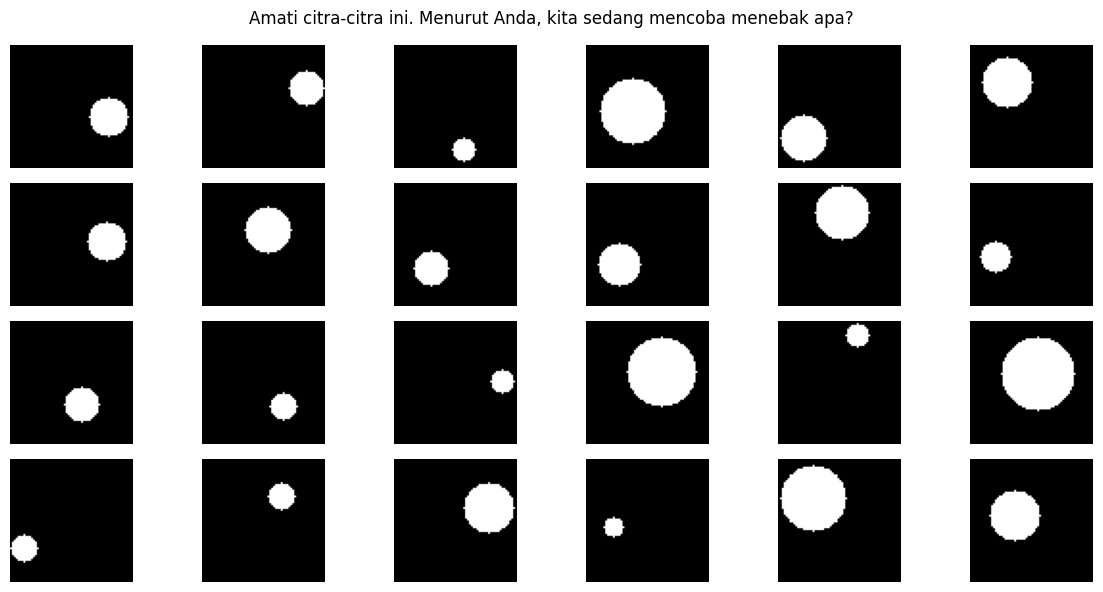

In [13]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

# Grid gambar tanpa label
cols = 6
rows = N_show // cols

plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')

plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()


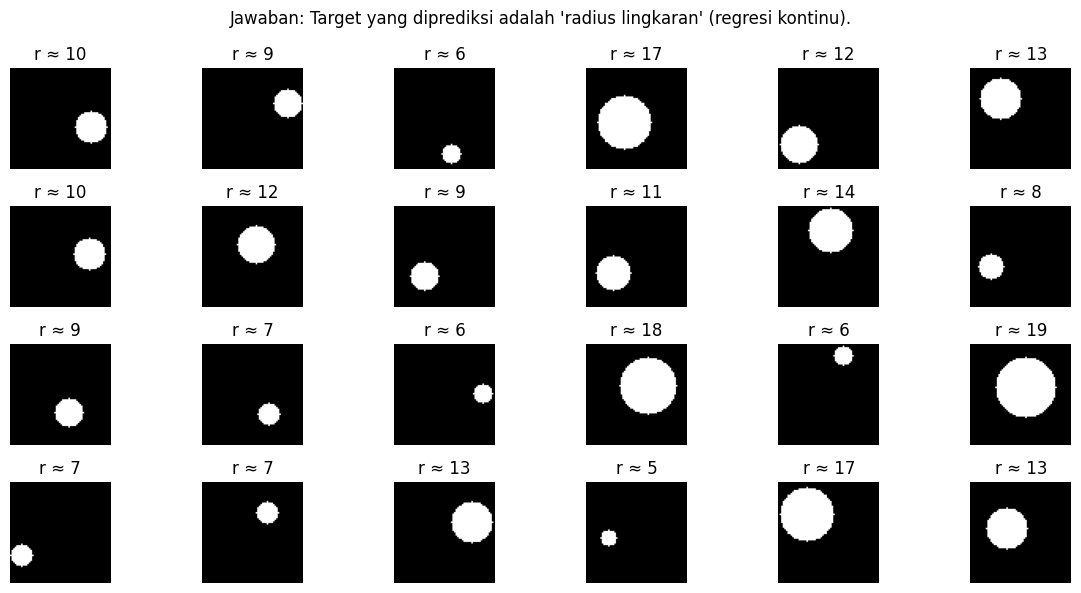

In [14]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"r ≈ {int(rads[i])}")
    plt.axis('off')

plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).")
plt.tight_layout()
plt.show()


In [15]:
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64,64,3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # output regresi
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    Xtr, ytr,
    validation_data=(Xte, yte),
    epochs=12,
    batch_size=64,
    verbose=1
)


Epoch 1/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 93.4011 - mae: 7.9527 - val_loss: 3.3420 - val_mae: 1.4567
Epoch 2/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.8201 - mae: 1.3320 - val_loss: 1.7227 - val_mae: 1.0702
Epoch 3/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5568 - mae: 1.0148 - val_loss: 1.6890 - val_mae: 1.0711
Epoch 4/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5221 - mae: 1.0127 - val_loss: 1.6516 - val_mae: 1.0467
Epoch 5/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5478 - mae: 1.0013 - val_loss: 1.6709 - val_mae: 1.0712
Epoch 6/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4728 - mae: 0.9960 - val_loss: 1.6400 - val_mae: 1.0600
Epoch 7/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4887 - mae: 0.9907 - val_loss: 1.6161 - val_mae: 1.0188
Epoch 8/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4484 - mae: 0.9738 - val_loss: 1.5812 - val_mae: 1.0301
Epoch 9/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.33

In [16]:
# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)

print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
MAE=0.996 | RMSE=1.238 | R²=0.933


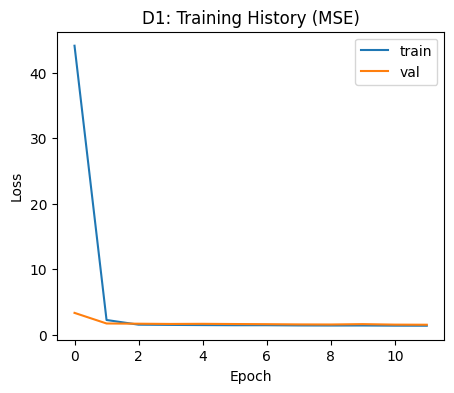

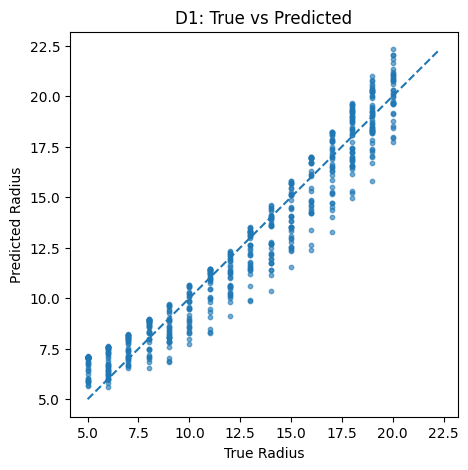

In [17]:
# Plot loss
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Scatter True vs Predicted
plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius")
plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()


Praktikum D3-Menilai "Kepopuleran Hewan Peliharaan" dari Foto(Pawpuliarity)

Langkah 1

In [18]:
from google.colab import files
files.upload()  # pilih kaggle.json dari komputer Anda

import os, shutil
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print("❌ kaggle.json belum ditemukan. Upload terlebih dahulu.")


Saving petfinder-pawpularity-score.zip to petfinder-pawpularity-score.zip
✅ Kaggle API siap digunakan.


Langkah 2

In [19]:
# Unduh dataset Pawpularity (sekitar 800MB)
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("✅ Dataset Pawpularity berhasil diekstrak.")


✅ Dataset Pawpularity berhasil diekstrak.


Langkah 3

                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

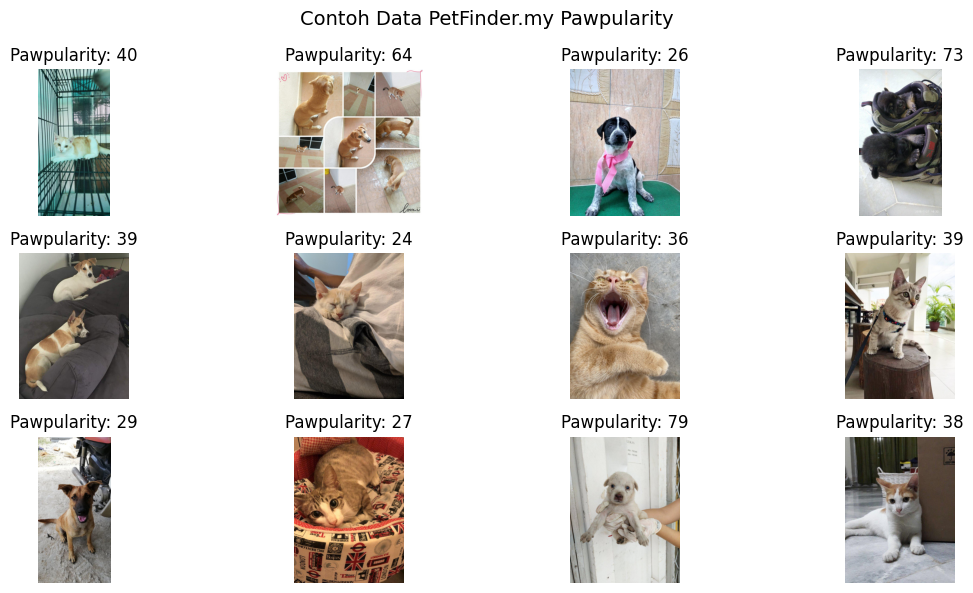

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
    img = Image.open(row.path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Pawpularity: {row.Pawpularity}")
    plt.axis('off')

plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()


Langkah 4

In [21]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity'])) \
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity'])) \
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(64).prefetch(tf.data.AUTOTUNE)

print(f"✅ Dataset siap digunakan — {len(train_df)} untuk training, {len(val_df)} untuk validasi.")


✅ Dataset siap digunakan — 7929 untuk training, 1983 untuk validasi.


Langkah 5

In [22]:
from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False  # freeze sementara

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Langkah 6

In [23]:
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)


Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 111s 512ms/step - loss: 805.3304 - mae: 21.3483 - val_loss: 474.0849 - val_mae: 16.0725 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 84s 199ms/step - loss: 419.0004 - mae: 15.1523 - val_loss: 426.7323 - val_mae: 15.2113 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - loss: 379.3579 - mae: 14.5144 - val_loss: 406.1918 - val_mae: 15.0000 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 194ms/step - loss: 367.3169 - mae: 14.3091 - val_loss: 392.4085 - val_mae: 14.5132 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 36s 194ms/step - loss: 355.5511 - mae: 14.0776 - val_loss: 382.6209 - val_mae: 14.3703 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 42s 236ms/step - loss: 341.6902 - mae: 13.6539 - val_loss: 375.0410 - val_mae: 14.1447 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 199ms/step - loss: 337.1542 - mae: 13.5319 - val_

Langkah 7

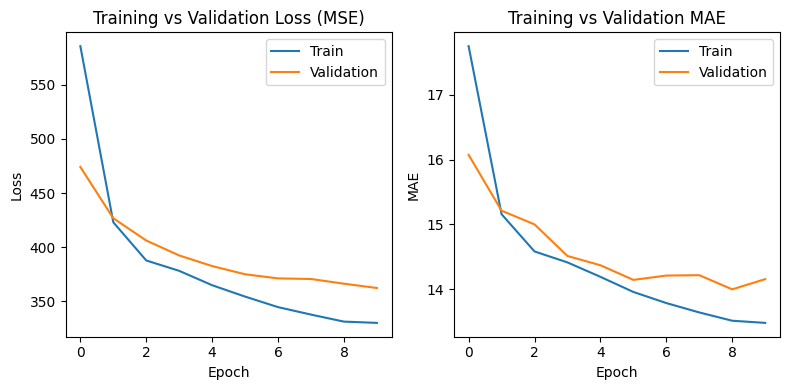

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()


Langkah 8

MAE  = 14.16
RMSE = 19.04
R²   = 0.180


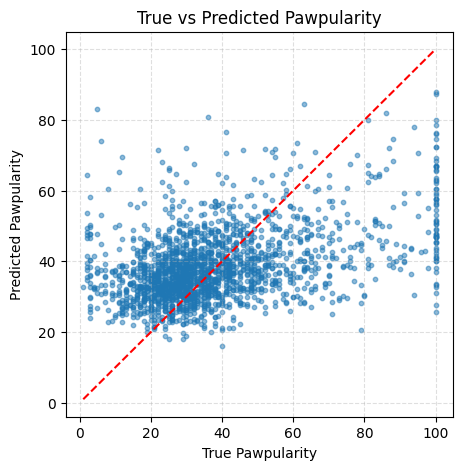

In [25]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in val_ds])

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)

print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


Langkah 9

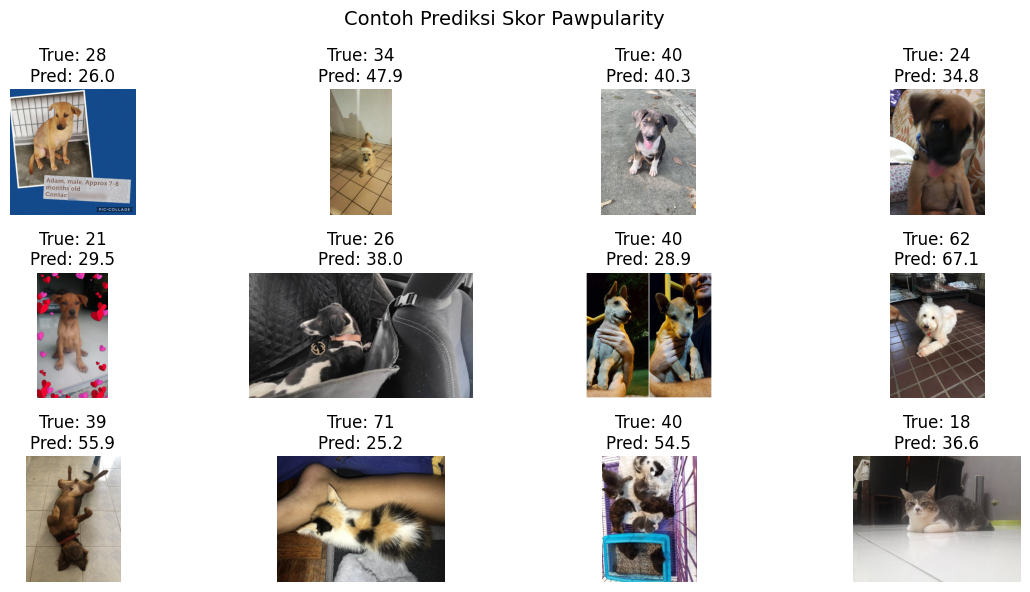

In [26]:
import random
from PIL import Image

sample_rows = val_df.sample(12, random_state=1)

plt.figure(figsize=(12, 6))
for i, row in enumerate(sample_rows.itertuples()):
    img = Image.open(row.path)
    pred = model.predict(tf.expand_dims(load_image(row.path, row.Pawpularity)[0], 0), verbose=0).ravel()[0]
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
    plt.axis('off')

plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()


Tantangan Mini

Tambahkan Data Augmentation

In [27]:
from tensorflow.keras import layers

augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

def load_aug(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    img = augment(img)
    return img, tf.cast(label, tf.float32)

train_ds_aug = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity'])) \
    .map(load_aug, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

model.fit(train_ds_aug, validation_data=val_ds, epochs=5)


Epoch 1/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 114s 503ms/step - loss: 344.2446 - mae: 13.7353 - val_loss: 362.9760 - val_mae: 14.2385
Epoch 2/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 117s 536ms/step - loss: 343.2986 - mae: 13.7376 - val_loss: 357.9920 - val_mae: 13.7659
Epoch 3/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 138s 505ms/step - loss: 323.1096 - mae: 13.3151 - val_loss: 358.2149 - val_mae: 13.7206
Epoch 4/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 142s 503ms/step - loss: 317.5446 - mae: 13.2427 - val_loss: 354.3358 - val_mae: 13.8458
Epoch 5/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 112s 497ms/step - loss: 322.0437 - mae: 13.3948 - val_loss: 357.5684 - val_mae: 13.7083


Gunakan EfficientNetB3 atau ResNet50

In [28]:
from tensorflow.keras import layers, models

base_b3 = tf.keras.applications.EfficientNetB3(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_b3.trainable = False

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base_b3(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model_b3 = tf.keras.Model(inputs, outputs)
model_b3.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_b3.fit(train_ds, validation_data=val_ds, epochs=5)


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 146s 698ms/step - loss: 917.4117 - mae: 22.7812 - val_loss: 488.4333 - val_mae: 16.1805
Epoch 2/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 238ms/step - loss: 449.5168 - mae: 15.6222 - val_loss: 416.4773 - val_mae: 15.1061
Epoch 3/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 86s 273ms/step - loss: 389.1451 - mae: 14.7615 - val_loss: 392.2724 - val_mae: 14.5793
Epoch 4/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 45s 263ms/step - loss: 374.2476 - mae: 14.4650 - val_loss: 379.5571 - val_mae: 14.4009
Epoch 5/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 51s 287ms/step - loss: 353.8280 - mae: 14.0542 - val_loss: 373.3655 - val_mae: 14.3521


Pisahkan Anjing vs Kucing

In [29]:
if 'Type' in df.columns:
    df['Type_name'] = df['Type'].map({1: 'Dog', 2: 'Cat'})
    print(df['Type_name'].value_counts())

    df_dog = df[df['Type'] == 1]
    df_cat = df[df['Type'] == 2]

    def make_ds(sub_df):
        return tf.data.Dataset.from_tensor_slices((sub_df['path'], sub_df['Pawpularity'])) \
            .map(load_image, num_parallel_calls=tf.data.AUTOTUNE) \
            .batch(64).prefetch(tf.data.AUTOTUNE)

    dog_ds = make_ds(df_dog)
    cat_ds = make_ds(df_cat)

    def eval_ds(ds, name):
        y_t = np.concatenate([b[1].numpy() for b in ds])
        y_p = np.concatenate([model.predict(b[0], verbose=0).ravel() for b in ds])
        mae = mean_absolute_error(y_t, y_p)
        print(f"{name} MAE = {mae:.3f}")

    eval_ds(dog_ds, "Dog")
    eval_ds(cat_ds, "Cat")
else:
    print("Kolom 'Type' tidak ditemukan pada dataset.")


Kolom 'Type' tidak ditemukan pada dataset.


Tambahkan Fitur Non-Visual (Brightness)

In [30]:
import tensorflow as tf
from tensorflow.keras import layers, models

def compute_brightness(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return tf.reduce_mean(img).numpy()

df['brightness'] = df['path'].apply(lambda p: compute_brightness(p))

def load_with_feat(path, label, brightness):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return (img, brightness), tf.cast(label, tf.float32)

paths = df['path'].values
labels = df['Pawpularity'].values.astype(np.float32)
brights = df['brightness'].values.astype(np.float32)

ds_feat = tf.data.Dataset.from_tensor_slices((paths, labels, brights)).map(
    lambda p, l, b: load_with_feat(p, l, b), num_parallel_calls=tf.data.AUTOTUNE
).batch(32).prefetch(tf.data.AUTOTUNE)

# Custom layer to reshape scalar input
class ReshapeFeature(layers.Layer):
    def call(self, inputs):
        return tf.reshape(inputs, (-1, 1))

# Model dengan dua input
image_input = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image_input')
feat_input = tf.keras.Input(shape=(), name='feature_input')

base = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
x = base(image_input)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)

# Reshape the feature input using the custom layer
reshaped_feat = ReshapeFeature()(feat_input)

merged = layers.Concatenate()([x, reshaped_feat])
merged = layers.Dense(128, activation='relu')(merged)
out = layers.Dense(1)(merged)

model_feat = tf.keras.Model(inputs=[image_input, feat_input], outputs=out)
model_feat.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_feat.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ image_input[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │    327,936 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_feature     │ (None, 1)         │          0 │ feature_input[0]… │
│ (ReshapeFeature)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 257)       │          0 │ dense_8[0][0],    │
│ (Concatenate)       │                   │            │ reshape_feature[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │     33,024 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │        129 │ dense_9[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,410,660 (16.83 MB)

 Trainable params: 4,368,637 (16.67 MB)

 Non-trainable params: 42,023 (164.16 KB)

Penugasan

1. Prediksi usia dari foto pribadi

Saving Nabila.jpeg to Nabila (1).jpeg


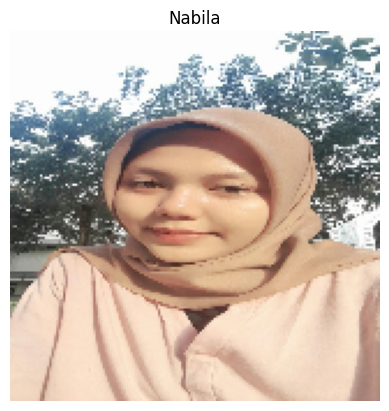

Perkiraan umur dari model: 35.0 tahun


In [33]:
from google.colab import files
uploaded = files.upload()

import tensorflow as tf
import matplotlib.pyplot as plt

IMG_SIZE = 160  # ukuran model UTKFace
img_path = list(uploaded.keys())[0]

img = tf.io.read_file(img_path)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

plt.imshow(img.numpy())
plt.axis('off')
plt.title("Nabila")
plt.show()

pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
print(f"Perkiraan umur dari model: {pred_age:.1f} tahun")

2. Uji Model Pawpularity

Saving Foto Hewan Peliharaan.jpg to Foto Hewan Peliharaan.jpg


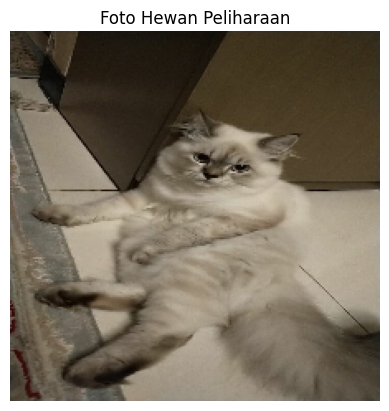

Perkiraan skor Pawpularity: 65.1/100


In [32]:
from google.colab import files
uploaded = files.upload()

import tensorflow as tf
import matplotlib.pyplot as plt

IMG_SIZE = 224
img_path = list(uploaded.keys())[0]

img = tf.io.read_file(img_path)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

plt.imshow(img.numpy())
plt.axis('off')
plt.title("Foto Hewan Peliharaan")
plt.show()

pred_score = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
print(f"Perkiraan skor Pawpularity: {pred_score:.1f}/100")